<a href="https://colab.research.google.com/github/xSakix/AI_colab_notebooks/blob/master/imdb_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB DNN

Lets do the IMDB dataset with a simple DNN. The first one is in numpy and second will be done in pytorch, but only using tensor for the GPU. Not using backwards or any NN functionality, as the goal is to implement it and learn how it works behind the scenes.

Last time i used a little dropout to the output layer. But it didn't really help. Let's try something else from NLP = embedding layer.

That means i will keep the inpu as it is (long) and add a new hidden layer after input, which will compute softmax over it.

As i have troubles implementing embeeding layer back propagation, i will try pytorch modules to see if it can even work.

In [1]:
import keras
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
import os


torch.manual_seed(2019)
np.random.seed(42)
EPS = torch.finfo(torch.float32).eps

max_features = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 


In [2]:
def convert_to_array(x):
    x_temp = []

    for x in x_train:
        if len(x) < maxlen:
            for i in range(maxlen - len(x)):
                x.append(0.0)
        elif len(x) > maxlen:
            x = x[0:maxlen]

        x_temp.append(x)

    return np.array(x_temp)


(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=max_features)
x_train = convert_to_array(x_train)
x_val = convert_to_array(x_val)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)

# x_train = x_train.reshape(x_train.shape[0], -1).T
# x_val = x_val.reshape(x_val.shape[0], -1).T

print("*" * 80)
print("x_train:{}".format(x_train.shape))
print("x_val:{}".format(x_val.shape))
print("y_train:{}".format(y_train.shape))
print("y_val:{}".format(y_val.shape))
print("*" * 80)

assert (x_train.shape == (25000,maxlen))
assert (y_train.shape == (25000,1))
assert (x_val.shape == (25000,maxlen))
assert (y_val.shape == (25000,1))

print("*" * 80)

print("max x_train before:{}".format(np.max(x_train)))
print("max x_val before:{}".format(np.max(x_val)))
print("min before:{}, {}".format(np.min(x_train), np.min(x_val)))

# norm didn't work well
# norm = np.linalg.norm(x_train, ord=2)
# print("norm={}".format(norm))

# normalizing around max_features works well
# x_train = x_train / max_features
# x_val = x_val / max_features

# centering around mean
# x_mean = np.mean(x_train)
# x_std = np.std(x_train)
# print("(mean,std)=({},{})".format(x_mean, x_std))
# x_train = (x_train - x_mean) / x_std
# x_val = (x_val - x_mean) / x_std

print("max x_train after norm:{}".format(np.max(x_train)))
print("max x_val after norm:{}".format(np.max(x_val)))
print("min after norm:{}, {}".format(np.min(x_train), np.min(x_val)))

# assert ((x_train >= 0.).all() and (x_train < 1.).all())

print("*" * 80)

print("y_train unique vals:{}".format(np.unique(y_train)))
print("y_val unique vals:{}".format(np.unique(y_train)))

print("*" * 80)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

********************************************************************************
x_train:(25000, 200)
x_val:(25000, 200)
y_train:(25000, 1)
y_val:(25000, 1)
********************************************************************************
********************************************************************************
max x_train before:19999.0
max x_val before:19999.0
min before:0.0, 0.0
max x_train after norm:19999.0
max x_val after norm:19999.0
min after norm:0.0, 0.0
********************************************************************************
y_train unique vals:[0 1]
y_val unique vals:[0 1]
********************************************************************************


In [9]:
class MyNet(torch.nn.Module):

  def __init__(self, num_tokens, vocab_size, emb_size, hidden_size):
    super(MyNet,self).__init__()
    self.emb = torch.nn.Embedding(vocab_size,emb_size)
    # print("num_tokens*emb_size={}".format(num_tokens*emb_size))
    self.dnn1 = torch.nn.Linear(num_tokens*emb_size,hidden_size)
    self.out = torch.nn.Linear(hidden_size,1)
    self.drop = torch.nn.Dropout(0.1)

  def forward(self,x):
    # print("x:{}".format(x.size()))
    e = self.emb(x)
    # print("e:{}".format(e.size()))
    f = e.reshape(e.shape[0],e.shape[1]*e.shape[2])
    f = self.drop(f)
    # print("f:{}".format(f.size()))
    #print(self.dnn1.weight.size())
    z1 = self.dnn1(f)
    # print("z1:{}".format(z1.size()))
    a1 = torch.nn.functional.relu(z1)
    # print("a1:{}".format(a1.size()))
    z2 = self.out(a1)
    # print("z2:{}".format(z2.size()))
    a2 = torch.sigmoid(z2)
    # print("a2:{}".format(a2.size()))
    return a2


In [4]:
def acc(y_hat,y):
  p = torch.round(y_hat).cuda()
  return torch.sum((p == y)/y.shape[0]).cuda()

In [10]:
#in torch the num samples is first
x_train = torch.tensor(x_train,dtype=torch.long).cuda()
x_val = torch.tensor(x_val,dtype=torch.long).cuda()
y_train = torch.tensor(y_train,dtype=torch.float32).cuda()
y_val = torch.tensor(y_val,dtype=torch.float32).cuda()

mynet = MyNet(num_tokens=x_train.shape[1],vocab_size=max_features, emb_size=300, hidden_size=128).cuda()

optimizer = torch.optim.SGD(mynet.parameters(), lr = 0.01)
loss_func = torch.nn.BCEWithLogitsLoss().cuda()

batch_size = 256

batches = np.array(list(range(0,x_train.shape[0],batch_size)))
n_b = len(batches)
costs = []
m_accs = []
m_val_accs=[]
for i in range(0, 4000):
  np.random.shuffle(batches)
  epoch_loss = 0.
  e_loss = 0.
  accs = 0.
  for idx in batches: 
    x_batch = x_train[idx:idx+batch_size,:]
    y_batch = y_train[idx:idx+batch_size,:]
    out = mynet(x_batch)
    accs += acc(out,y_batch)
    loss = loss_func(out, y_batch)
    e_loss+=loss
    epoch_loss+=loss.item()
  
  mynet.zero_grad()
  e_loss.backward()
  optimizer.step()

  if i % 100 == 0:
    val_accs = 0.
    with torch.no_grad():
      for idx in batches: 
        x_batch = x_val[idx:idx+batch_size,:]
        y_batch = y_val[idx:idx+batch_size,:]
        out = mynet(x_batch)
        val_accs += acc(out,y_batch)
    costs.append(epoch_loss/n_b)
    m_accs.append(accs/n_b)
    m_val_accs.append(val_accs/n_b)
    print("{}, {}, {}".format(epoch_loss/n_b, accs/n_b,val_accs/n_b))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct 

0.7255510864209156, 0.49829360842704773, 0.49995821714401245
0.6233412897100254, 0.7246226668357849, 0.5001556277275085
0.6006534002265151, 0.7451921701431274, 0.5016722083091736
0.6045491257492377, 0.734149158000946, 0.5016513466835022
0.5971736999190583, 0.7534241080284119, 0.5023497939109802
0.5904396158091876, 0.7712451815605164, 0.5020138621330261
0.5983025510700382, 0.7500360012054443, 0.502051830291748
0.6002295096309818, 0.7444556951522827, 0.5011938810348511
0.5797206765534927, 0.7991089820861816, 0.502252995967865
0.5928389527359788, 0.764467179775238, 0.5015754103660583
0.5997062112603869, 0.7462095022201538, 0.50139319896698
0.587320116101479, 0.7783212065696716, 0.5016760230064392
0.5845319920656632, 0.7866519093513489, 0.5009186863899231
0.6023900861642799, 0.7391923069953918, 0.5013134479522705
0.5760238426072257, 0.8096926808357239, 0.5012375712394714
0.5577029853451009, 0.861402153968811, 0.4995254874229431
0.5931980378773748, 0.7633112668991089, 0.5018145442008972
0.5

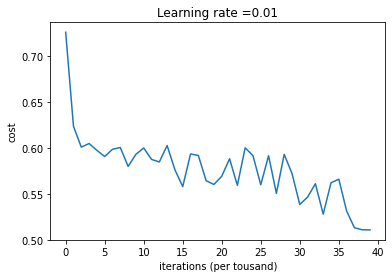

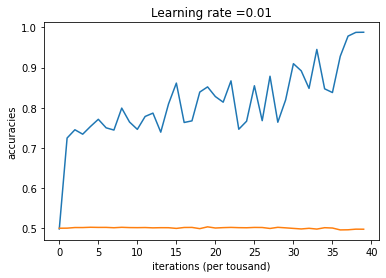

In [11]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tousand)')
plt.title("Learning rate =" + str(0.01))
plt.show()

plt.plot(m_accs)
plt.plot(m_val_accs)
plt.ylabel('accuracies')
plt.xlabel('iterations (per tousand)')
plt.title("Learning rate =" + str(0.01))
plt.show()

# summary

After adding embeddings it didn't help at all actualy.
Best we try lstm here next...if it doesn't help we have problem somewhere else.